# Netflix Recommender System - (Draft1)

<u>Summary of all the steps done in this notebook:</u>
- directories for datasets have been set
- dataset file names have been stored in different variables


<u>For IMDB Work:</u>
- Data Dictionary for IMDB datafile: https://www.imdb.com/interfaces/
- Location for IMDB datafiles: https://datasets.imdbws.com/
- "\N" represents missing or null values in IMDB datasets. These have been replaced with np.nan


<p>since the "\\" denotes escape character, regex has been applied to avoid the below error: 
    
<b>SyntaxError:</b> (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape<p>

### Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

from cycler import cycler

%matplotlib inline

### Set default options

In [2]:
pd.options.display.max_colwidth = 100
plt.style.use('dark_background')
plt.rcParams["axes.prop_cycle"] = cycler('color', ["#f50000", "#f00000", "#e60000", "#e00000", "#db0000", "#d10000", 
                                                   "#cc0000", "#c70000", "#bd0000", "#b80000", "#b30000", "#a80000", 
                                                   "#a30000", "#9e0000", "#940000"])
plt.rcParams["figure.figsize"] = [15, 4]
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "ultralight"

In [3]:
# plt.rcParams

In [4]:
# directory that contains netflix dataset
net_dir = os.getcwd() + "\\Netflix_Dataset\\"

# zip file containing netflix dataset
net_zipfile = "Netflix_Titles.zip"

# Read the file and save in raw dataframe
netflix_raw_data = pd.read_csv(net_dir + net_zipfile)

In [5]:
# info and describe raw dataframe
netflix_raw_data.info()
netflix_raw_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [6]:
# check for any duplicate records
print("No. of duplicated records (if any):", netflix_raw_data.duplicated().sum())

No. of duplicated records (if any): 0


In [7]:
# content category
netflix_raw_data["type"].value_counts()

Movie      5377
TV Show    2410
Name: type, dtype: int64

In [8]:
# sample rows from netflix dataset
netflix_raw_data.tail(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & Musicals","In this documentary, South African rapper Nasty C hits the stage and streets of Tokyo, introduci..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the next “Willy Wonka” in this tense competition that fin...
7786,s7787,Movie,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,Sam Dunn,NaN,"United Kingdom, Canada, United States","March 1, 2020",2019,TV-MA,90 min,"Documentaries, Music & Musicals",This documentary delves into the mystique behind the blues-rock trio and explores how the enigma...


In [9]:
# this block of code only displays columns which have missing data and the % of rows with the missing values
null_column_list = []

# total no. of rows in dataset
total_rows = netflix_raw_data.shape[0]

for each_col in netflix_raw_data.columns:
    if netflix_raw_data[each_col].isnull().sum() > 0:
        null_sum = netflix_raw_data[each_col].isnull().sum()
        null_perc = "{:.4f}".format(null_sum / total_rows * 100)
        
        null_column_list.append([each_col, null_sum, null_perc])
        
# delete the dummy variable        
del total_rows
        
# display missing row count and % as a dataframe    
pd.DataFrame(null_column_list, columns = ["Column Name", "No. of rows with missing values", 
                                          "Missing value as % (Netflix Dataset)"])

,Column Name,No. of rows with missing values,Missing value as % (Netflix Dataset)
0,director,2389,30.6793
1,cast,718,9.2205
2,country,507,6.5109
3,date_added,10,0.1284
4,rating,7,0.0899


For the date_added column, we can't be sure as to when exactly the show was added to Netflix, so we will simply remove these records. 

Since the rating column has only 7 values missing, let's identify these titles and try to fill-up the rating column with the help of IMDB. Ofcourse this process is manual.

## Explore Netflix Dataset

### type Column

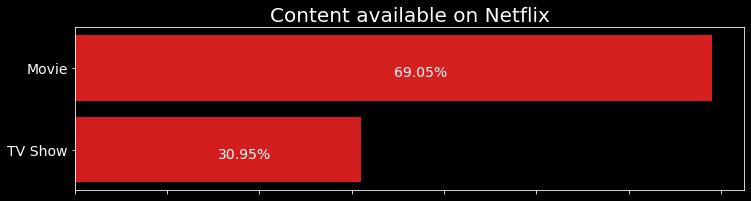

In [10]:
fig,ax = plt.subplots(figsize = (12,3))

# plot content type as percentage
sns.barplot(y = netflix_raw_data["type"].value_counts(normalize = True).index,
            x = netflix_raw_data["type"].value_counts(normalize = True).mul(100).values, 
            ax = ax)

ax.set_title("Content available on Netflix")
ax.set_xticklabels("")

# annotate each bar
for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_width()), [p.get_width()/ 2, p.get_y() + 0.5])
    
plt.show()    

### rating Column

In [11]:
# identify the titles with missing-values
netflix_raw_data.loc[netflix_raw_data["rating"].isnull(), ["title", "director", "release_year", "rating"]]

,title,director,release_year,rating
67,13TH: A Conversation with Oprah Winfrey & Ava DuVernay,NaN,2017,NaN
2359,Gargantia on the Verdurous Planet,NaN,2013,NaN
3660,Little Lunch,NaN,2015,NaN
3736,Louis C.K. 2017,Louis C.K.,2017,NaN
3737,Louis C.K.: Hilarious,Louis C.K.,2010,NaN
3738,Louis C.K.: Live at the Comedy Store,Louis C.K.,2015,NaN
4323,My Honor Was Loyalty,Alessandro Pepe,2015,NaN


In [12]:
# dictionary to map title with ratings (Copied from Mike's work)
ratings_map = {idx:val for idx,val in zip(netflix_raw_data.loc[netflix_raw_data["rating"].isnull(), "title"].values, 
                                          ["TV-PG", "TV-14", "TV-Y7", "TV-MA", "TV-MA", "TV-MA", "PG-13"])}
# display ratings dictionary
ratings_map

{'13TH: A Conversation with Oprah Winfrey & Ava DuVernay': 'TV-PG',
 'Gargantia on the Verdurous Planet': 'TV-14',
 'Little Lunch': 'TV-Y7',
 'Louis C.K. 2017': 'TV-MA',
 'Louis C.K.: Hilarious': 'TV-MA',
 'Louis C.K.: Live at the Comedy Store': 'TV-MA',
 'My Honor Was Loyalty': 'PG-13'}

In [13]:
# replace the missing ratings
netflix_raw_data["rating"] = netflix_raw_data["title"].map(ratings_map).fillna(netflix_raw_data["rating"])

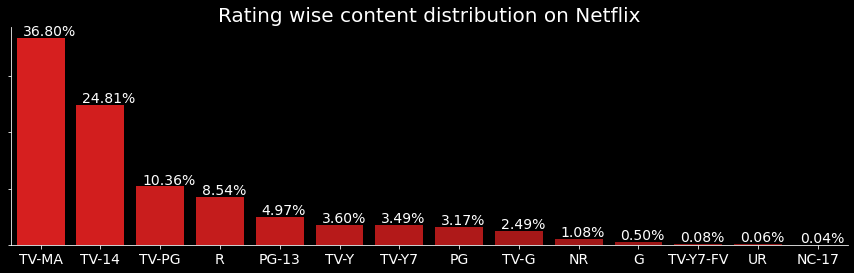

In [14]:
fig, ax = plt.subplots() # figsize = (15, 5))

# plot distribution of titles as % based on the rating column
sns.barplot(x = netflix_raw_data["rating"].value_counts(normalize = True).index,
            y = netflix_raw_data["rating"].value_counts(normalize = True).mul(100).values, 
            ax = ax)

ax.set_title("Rating wise content distribution on Netflix")
ax.set_yticklabels("")

for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_height()), [p.get_x() + 0.1, p.get_height() + 0.5],)

sns.despine()
plt.show()

### date_added Column & release Column

- The format in netflix dataset for this column is "Month Day, Year" and is of object dtype. We will first change this to pandas datetime format
- Also, since the column has 10 missing values, we will remove those rows

- Can't really trust the release year column since if a title has been running for multiple seasons, netflix dataset may only have the most recent release year

In [15]:
from datetime import datetime as dt

In [16]:
# convert to datetime format
netflix_raw_data["date_added"] = pd.to_datetime(netflix_raw_data["date_added"])

# select only those records where date_added column has values
netflix_raw_data = netflix_raw_data[netflix_raw_data["date_added"].notna()]

# shape of resultant netflix_raw_data
netflix_raw_data.shape

(7777, 12)

#### Additional Analysis

This is a small analysis of:
- distribution of titles based on the decade they were released
- distribution of titles hosted by Netflix since it's inception

For ease of plotting:
- the titles that were released before the year 1980, have been grouped under `Before 1980`. Why this year? because I was born in this decade!
- since Netflix established itself in 190 countries by 2016, all the titles added (on Netflix platform) before 2016 have been grouped under `Added before 2016`.

Tried this analysis with two charts - Pie and Line.

In [17]:
# calculate the decade for each year of release
decade_df = (netflix_raw_data["release_year"] // 10 * 10).value_counts().reset_index()

# rename the dataframe columns
decade_df.rename(columns = {"index": "Decade", "release_year" : "No. of Titles"}, inplace = True)

# identify titles released before the year 1980 
decade_df["Decade"] = decade_df["Decade"].apply(lambda d: d if d > 1980 else "Before 1980")

# label each decade as YYYY's
decade_df["Decade"] = decade_df["Decade"].astype(str).apply(lambda s: s + "'s")

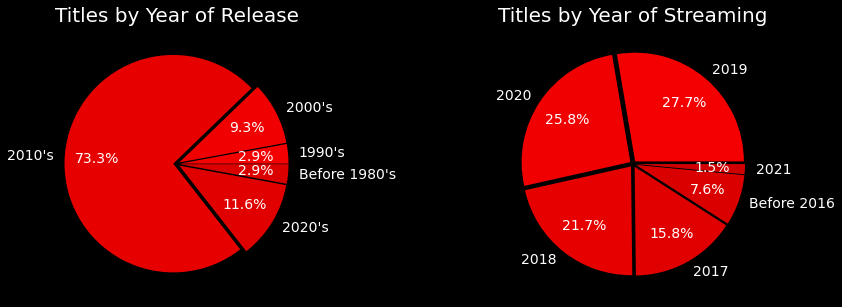

In [18]:
fig, ax = plt.subplots(figsize = (15, 5), ncols = 2)

# group the no. of titles by decade in which they were released
data = decade_df.groupby("Decade")["No. of Titles"].sum()

# plot the years when title was released
ax[0].pie(x = data.values, 
          labels = data.index,
          autopct = "%.1f%%",
          explode = [0.03] * len(data),
          pctdistance = 0.7)
ax[0].set_title("Titles by Year of Release")

# group the no. of titles by decade in which they were added to Netflix
data = netflix_raw_data["date_added"].dt.year.apply(lambda d: d if d > 2016 else "Before 2016").value_counts()

# plot the years when title was added
ax[1].pie(x = data.values,
          labels = data.index,
          autopct = "%.1f%%",
          explode = [0.03] * len(data),
          pctdistance = 0.7)
ax[1].set_title("Titles by Year of Streaming")

plt.show()

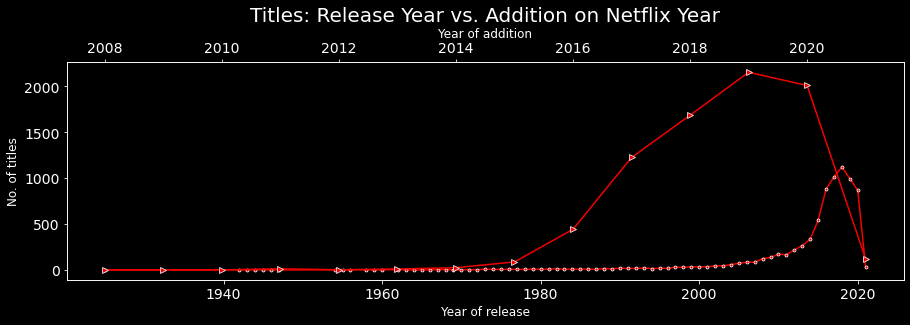

In [19]:
# Compare release year and the year title was added to Netflix

# release year plot
sns.lineplot(data = netflix_raw_data["release_year"].value_counts(), marker = ".")
plt.xlabel("Year of release")
plt.ylabel("No. of titles")

# twin the first plot 
plt.twiny()

# plot for year of addition of title
sns.lineplot(data = netflix_raw_data["date_added"].dt.year.value_counts(), marker = ">")
plt.xlabel("Year of addition")

plt.title("Titles: Release Year vs. Addition on Netflix Year")

# show figure
plt.show()

### duration Column

This column specifies the duration of a title in No. of seasons or runtime in minutes. However, if we analyze the values, the TV Shows are specified with seasons and Movies have runtime minutes. No series has runtime in minutes.

In [20]:
# title type with duration in seasons
print(netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("Season"), "type"].value_counts(), "\n")

# title type with duration in minutes
print(netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "type"].value_counts())

TV Show    2400
Name: type, dtype: int64 

Movie    5377
Name: type, dtype: int64


In [21]:
netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("Season"), "duration"].value_counts()

1 Season      1608
2 Seasons      378
3 Seasons      183
4 Seasons       86
5 Seasons       57
6 Seasons       30
7 Seasons       19
8 Seasons       18
9 Seasons        8
10 Seasons       5
11 Seasons       2
15 Seasons       2
12 Seasons       2
16 Seasons       1
13 Seasons       1
Name: duration, dtype: int64

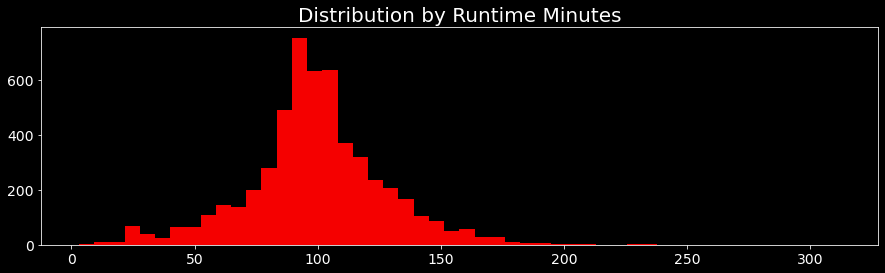

In [22]:
# distribution of runtime in minutes
plt.hist(x = netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "duration"].\
         str.strip("min").astype(int), 
         bins = 50)
plt.title("Distribution by Runtime Minutes")
plt.show()

### Section for listed_in Column


In [23]:
# listed_in sample values

## Tackle the Missing Values

Now we come to the big bad boy: Missing Values in 3 columns - Director, Cast and Country of origin of a title. 
The idea is to try out the best approach and fillin as many missing values as we can.

In [24]:
# Set-up directory and Files
imdb_dir = os.getcwd() + "\\IMDB_Dataset\\"
imdb_file_names = ["title_akas.tsv", "title_basics.tsv", "title_crew.tsv", "title_principals.tsv", "name_basics.tsv"]

In [25]:
# import the IMDB_work.py module
import IMDB_work as iw

In [26]:
""" Read the title_basics.tsv file """
title_basics = iw.read_imdb_files(file_name = imdb_file_names[1], file_directory = imdb_dir)

The data file title_basics.tsv contains 7918519 rows and 9 columns
------------------------------------------------------------
       ColumnName  MissingValue%
0          tconst           0.00
1       titleType           0.00
2    primaryTitle           0.00
3   originalTitle           0.00
4         isAdult           0.00
5       startYear          10.95
6         endYear          99.03
7  runtimeMinutes          72.08
8          genres           7.81


In [27]:
# split the dataframe with missing and non-missing values
missing_df = netflix_raw_data[(netflix_raw_data["director"].isnull()) |
                              (netflix_raw_data["cast"].isnull()) |
                              (netflix_raw_data["country"].isnull())]

netflix_data = netflix_raw_data[(netflix_raw_data["director"].notna()) &
                                (netflix_raw_data["cast"].notna()) &
                                (netflix_raw_data["country"].notna())]

In [28]:
missing_df.shape, netflix_data.shape

((2965, 12), (4812, 12))

To compare the common titles between title_basics dataset and missing_df:
- both the title and primaryTitle columns have been stripped of any non alpha-numeric characters
- the titles have been set to lower case
- release_year and startYear columns have been appended to the title name columns respectively

In [29]:
# Filter out records where primaryTitle ad startYear in imdb_df matches with title and release year from missing_df
missing_df_combo = missing_df["title"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                   str.cat(missing_df["release_year"].astype(str))

In [30]:
title_basics_combo = title_basics["primaryTitle"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                     str.cat(title_basics["startYear"].astype(str))

In [31]:
title_basics[title_basics_combo.isin(missing_df_combo)].shape

(2780, 9)